In [258]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler

pd.options.display.max_columns = 15
pd.options.display.max_rows = 20
%matplotlib inline

plt.rcParams["figure.figsize"] = (20,8)
plt.style.use('dark_background')

# Analysis of Real Estate Data

In [259]:
rent_df = pd.read_csv("data/real_estate/fresh_rent_data.csv", parse_dates=True)
rent_df = rent_df.replace('None', np.nan)

In [260]:
rent_df['living_area'] = rent_df['living_area'].astype(np.float64)
rent_df['date'] = pd.to_datetime(rent_df['date'])
rent_df['lot_area'] = rent_df['lot_area'].astype(np.float64)
rent_df['area'] = rent_df['area'].astype(np.float64)
rent_df['beds'] = rent_df['beds'].astype(np.float64)
rent_df['baths'] = rent_df['baths'].astype(np.float64)
rent_df = rent_df.rename({"BOROUGH": "borough"}, axis=1)
rent_df = rent_df.drop(['zillow_id'], axis=1)

The structure of the data is:

In [261]:
rent_df

,date,event_description,price,address_city,zip_code,area,status_type,home_type,beds,baths,living_area,lot_area,borough
0,2021-04-16,Listed for rent,1500,Maspeth,11378.0,NaN,FOR_RENT,APARTMENT,1.0,1.0,NaN,NaN,queens
1,2021-03-03,Price change,1300,Maspeth,11378.0,350.0,FOR_RENT,APARTMENT,0.0,1.0,350.0,NaN,queens
2,2021-02-17,Listed for rent,1350,Maspeth,11378.0,350.0,FOR_RENT,APARTMENT,0.0,1.0,350.0,NaN,queens
3,2021-04-10,Listed for rent,3000,Maspeth,11378.0,NaN,FOR_RENT,MULTI_FAMILY,3.0,1.0,NaN,NaN,queens
4,2021-03-23,Listed for rent,3200,Flushing,11378.0,3000.0,FOR_RENT,SINGLE_FAMILY,3.0,2.5,3000.0,2500.0,queens
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48316,2021-03-13,No price history,2500,Bayside,11361.0,1100.0,FOR_RENT,APARTMENT,3.0,1.5,1100.0,NaN,queens
48317,2021-03-12,No price history,2400,Bayside,11361.0,NaN,FOR_RENT,APARTMENT,4.0,2.0,NaN,NaN,queens
48318,2021-02-01,No price history,2299,Bayside,11361.0,1000.0,FOR_RENT,MULTI_FAMILY,3.0,2.0,1000.0,NaN,queens
48319,2021-01-04,No price history,2274,Bayside,11361.0,NaN,FOR_RENT,MULTI_FAMILY,1.0,1.0,NaN,NaN,queens


Our analysis starts from 06/01/2019 so we need to remove the properties with a date
before 06/01/2019

In [262]:
start = datetime.datetime(2019, 6, 1)
end = datetime.datetime(2021, 4, 1)
rent_df = rent_df[(rent_df['date'] >= start) & (rent_df['date'] <= end)]

We divide the data into boroughs to analyze them individually

In [263]:
rent_ny = {
    'queens': rent_df[rent_df['borough'] == 'queens'],
    'bronx': rent_df[rent_df['borough'] == 'bronx'],
    'brooklyn': rent_df[rent_df['borough'] == 'brooklyn'],
    'staten': rent_df[rent_df['borough'] == 'staten_island'],
    'manhattan': rent_df[rent_df['borough'] == 'manhattan'],
}

# Time Series Analysis on Manhattan

In [264]:
manhattan_df = rent_ny['manhattan']
print(manhattan_df['price'].describe())

count    12620.000000
mean      3494.927258
std       2179.796099
min        500.000000
25%       2075.000000
50%       2700.000000
75%       3995.000000
max      15000.000000
Name: price, dtype: float64


Remove outliers from the data

In [265]:
manhattan_df.drop(manhattan_df[manhattan_df['price'] > 7_000].index, inplace=True)

/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [266]:
# Create a time series for average price, median price, and count  from the manhattan dataframe
idx = pd.date_range(start, end)
manhattan_ts = manhattan_df.groupby(manhattan_df.date)['price'].agg(['mean','count', 'median'])
manhattan_ts.index = pd.DatetimeIndex(manhattan_ts.index)
manhattan_ts = manhattan_ts.reindex(idx)
manhattan_ts

,mean,count,median
2019-06-01,3200.000000,1.0,3200.0
2019-06-02,NaN,NaN,NaN
2019-06-03,4247.500000,2.0,4247.5
2019-06-04,2800.000000,1.0,2800.0
2019-06-05,3721.000000,3.0,2850.0
...,...,...,...
2021-03-28,2895.207048,227.0,2500.0
2021-03-29,2885.548822,297.0,2500.0
2021-03-30,2941.651297,347.0,2600.0
2021-03-31,2841.966245,237.0,2500.0


Plot of the raw time series for Manhattan

<AxesSubplot:>

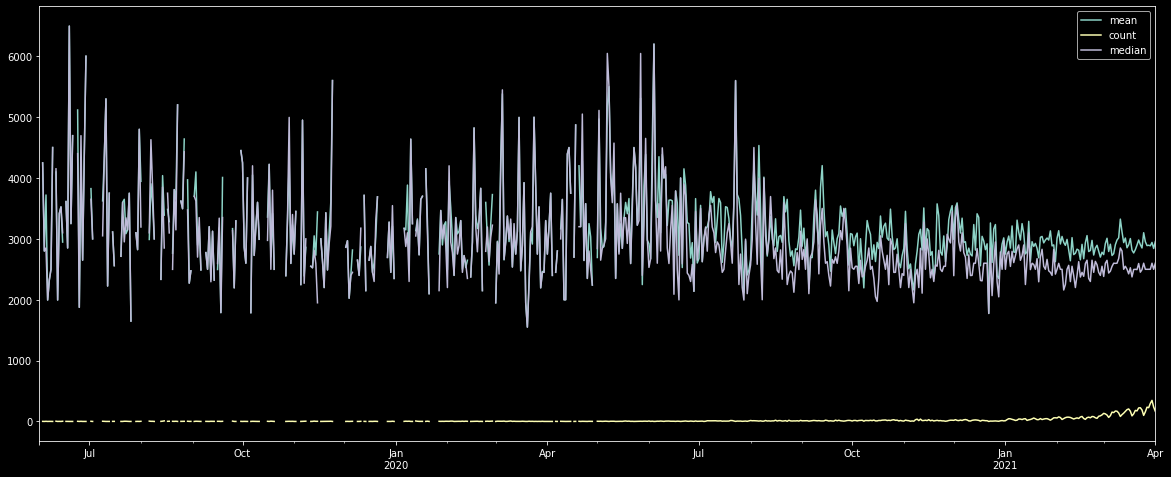

In [267]:
manhattan_ts.plot()


We need to fill in missing values. We use interpolation to do so

In [268]:
manhattan_ts = manhattan_ts.interpolate(method='spline', order=2)


/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/scipy/interpolate/fitpack2.py:279: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


Now we need to smooth the data using a rolling window of 5 days and scale the data using min-max scaling.

Comparison between different smoothing options:

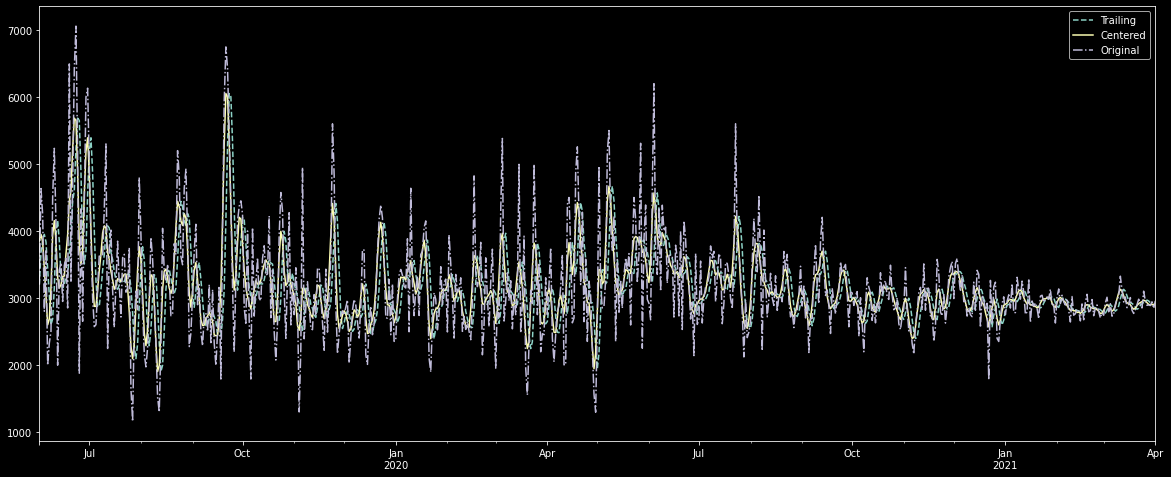

In [269]:
fig, ax = plt.subplots()
smoothed_df_trailing = manhattan_ts['mean'].rolling(5, win_type='triang', min_periods=1).mean()
smoothed_df_trailing.plot(style='--', legend=True, ax=ax)
smoothed_df_centered = manhattan_ts['mean'].rolling(5, win_type='triang', min_periods=1, center=True).mean()
smoothed_df_centered.plot(legend=True, ax=ax)
smoothed_df_not_smoothed = manhattan_ts['mean']
smoothed_df_not_smoothed.plot(style='-.', legend=True, ax=ax)
ax.legend(["Trailing", "Centered", "Original"])

We might need to use a trailing window because we are trying to forecast into the future.

<AxesSubplot:>

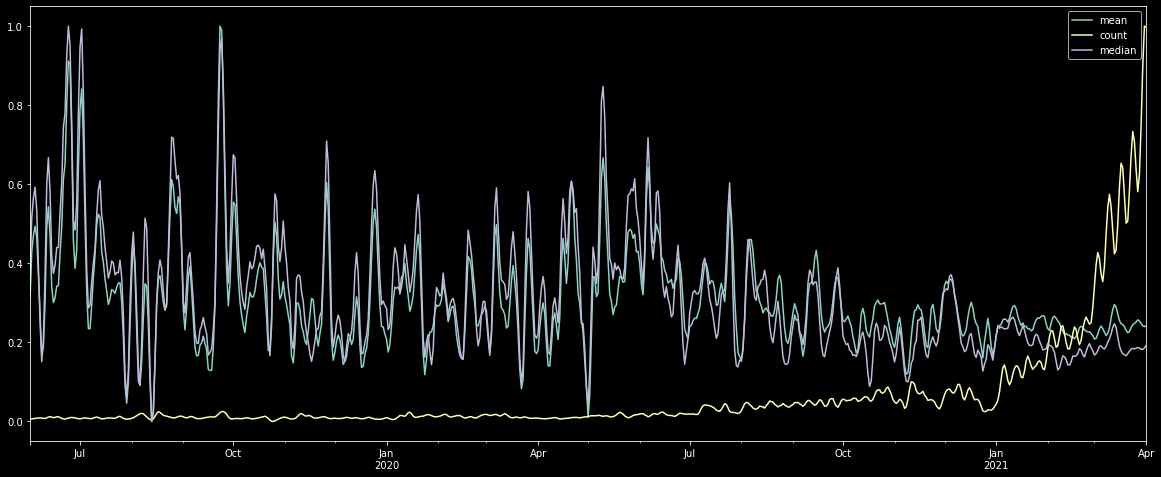

In [270]:
scaler = MinMaxScaler()
smoothed_df = manhattan_ts.rolling(5, win_type='triang', min_periods=1).mean()
smoothed_df = pd.DataFrame(scaler.fit_transform(smoothed_df), index=smoothed_df.index, columns=smoothed_df.columns)
smoothed_df.plot()

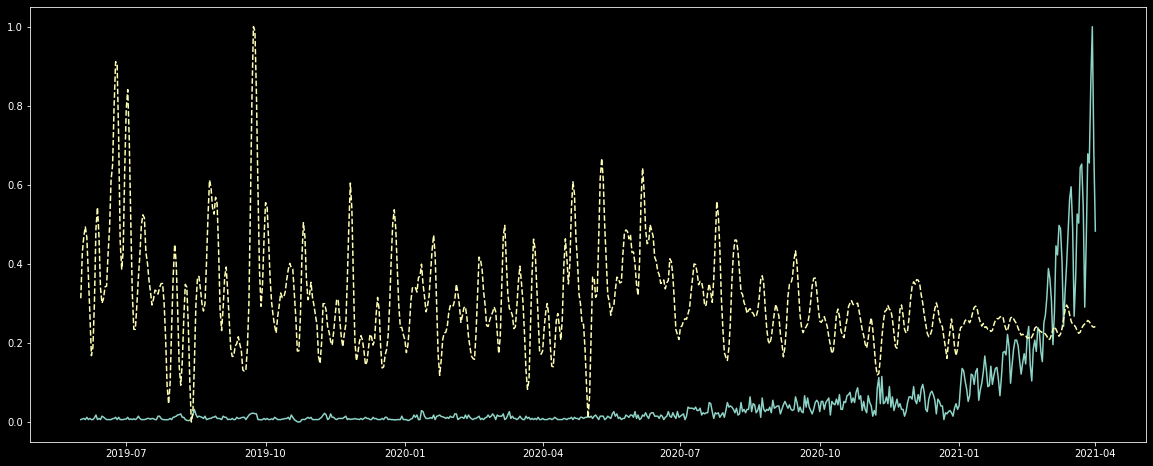

In [271]:
plt.plot(manhattan_ts.index, scaler.fit_transform(manhattan_ts[['count']]))
plt.plot(smoothed_df.index, smoothed_df['mean'], ls='--')
plt.show()

We now explore the price/sqr_feet instead of just the price.

In [272]:
price_sqft = manhattan_df[~manhattan_df['area'].isna()].sort_values('date')
price_sqft['price_per_area'] = price_sqft['price']/price_sqft['area']

<AxesSubplot:>

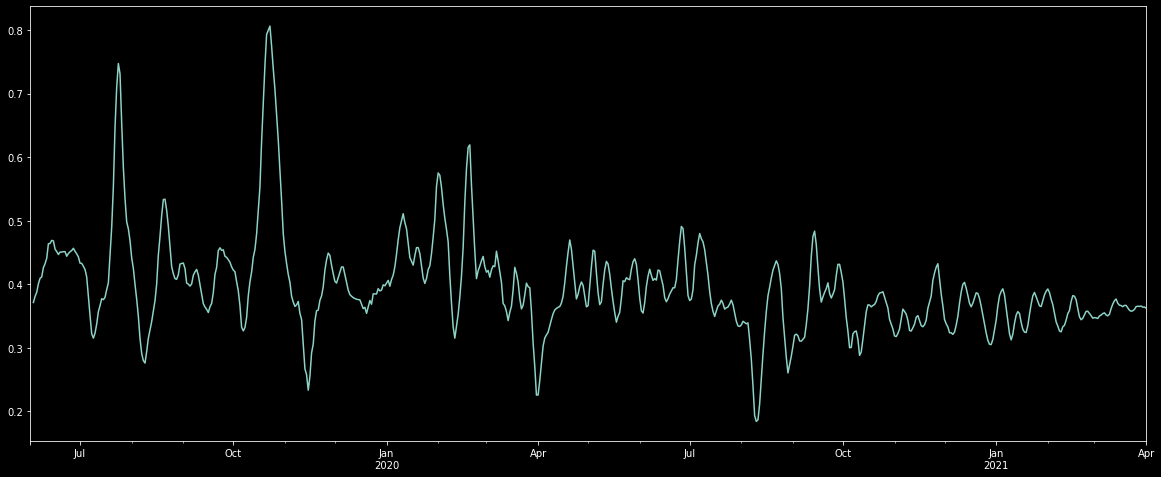

In [273]:
modified_manhattan_ts = price_sqft.groupby(price_sqft.date)['price_per_area'].agg(['mean', 'max', 'min', 'median'])
modified_manhattan_ts = modified_manhattan_ts.reindex(idx)
modified_manhattan_ts = modified_manhattan_ts.interpolate(method='spline', order=2)
modified_manhattan_ts = pd.DataFrame(scaler.fit_transform(modified_manhattan_ts), index=modified_manhattan_ts.index,
                                     columns=modified_manhattan_ts.columns)
modified_manhattan_ts = modified_manhattan_ts.rolling(7, win_type='triang', min_periods=1).mean()
modified_manhattan_ts['mean'].plot()

# Introducing COVID data

In [274]:
nyc_covid_df = pd.read_csv("data/covid/covid_nyc.csv")
nyc_covid_df.set_index("date", drop=True)
nyc_covid_df.drop(['city_pop2019', 'cityname', 'statename', 'statefips'], axis=1, inplace=True)
nyc_covid_df['date'] = pd.to_datetime(nyc_covid_df['date'])
nyc_covid_df = nyc_covid_df[(nyc_covid_df['date'] >= start) & (nyc_covid_df['date'] <= end)]
nyc_covid_df = nyc_covid_df.set_index('date', drop=True)

Covid raw data: 

<AxesSubplot:xlabel='date'>

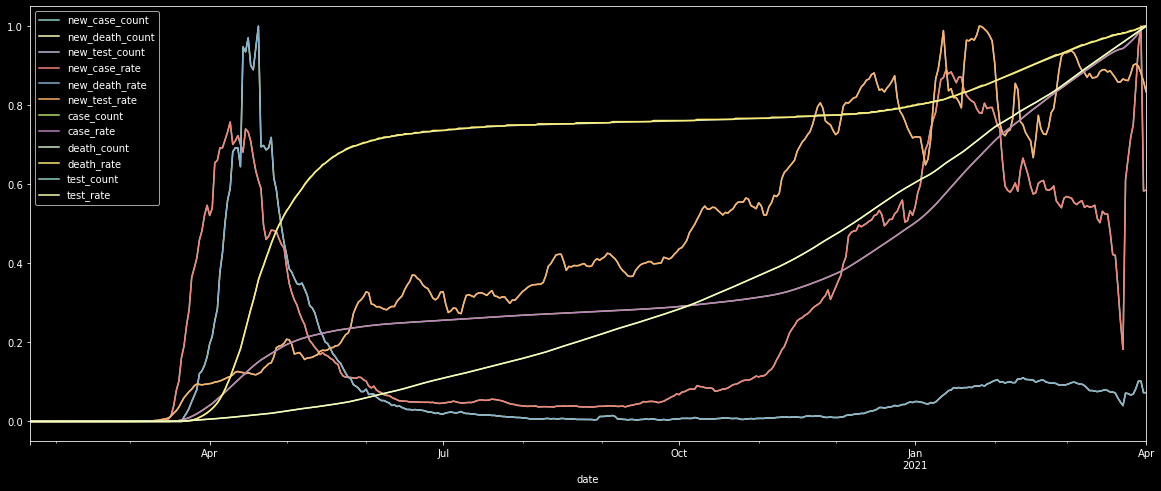

In [275]:
nyc_covid_df = pd.DataFrame(scaler.fit_transform(nyc_covid_df), columns=nyc_covid_df.columns, index=nyc_covid_df.index)
nyc_covid_df.plot()


In [276]:
new_case_rate = nyc_covid_df['new_case_rate'].rolling(7, win_type='triang', min_periods=1).mean()
case_rate = nyc_covid_df['case_rate'].rolling(7, win_type='triang', min_periods=1).mean()

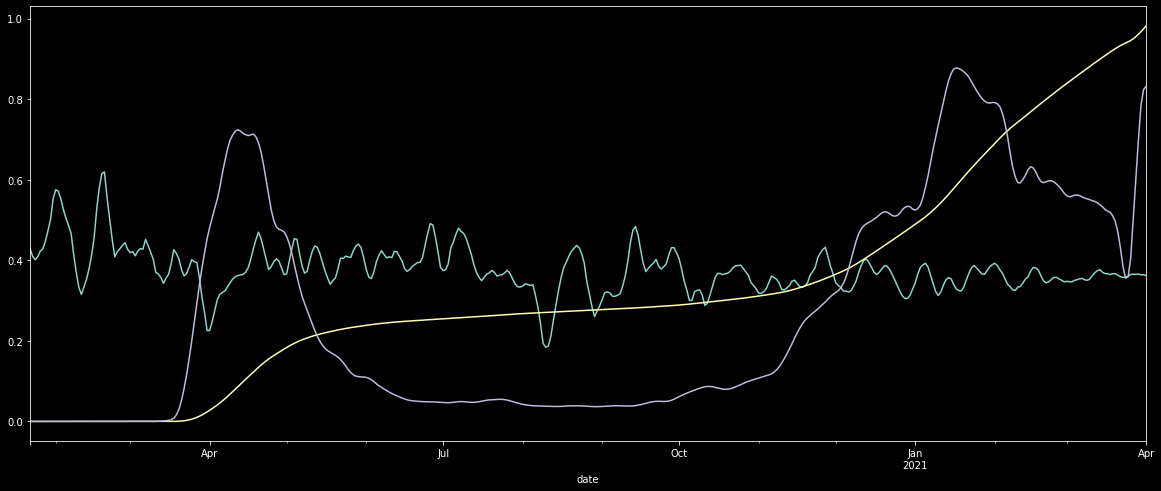

In [277]:
plt.figure()
modified_manhattan_ts[modified_manhattan_ts.index >= case_rate.index.min()]['mean'].plot()
case_rate.plot()
new_case_rate.plot()
plt.show()

# Seasonal Decompositions

Decomposition is the process of understanding generalizations and problems related to time-series forecasting. 
We can leverage seasonal decomposition to remove seasonality from data and check the data only with the trend,
cyclic, and irregular variations.

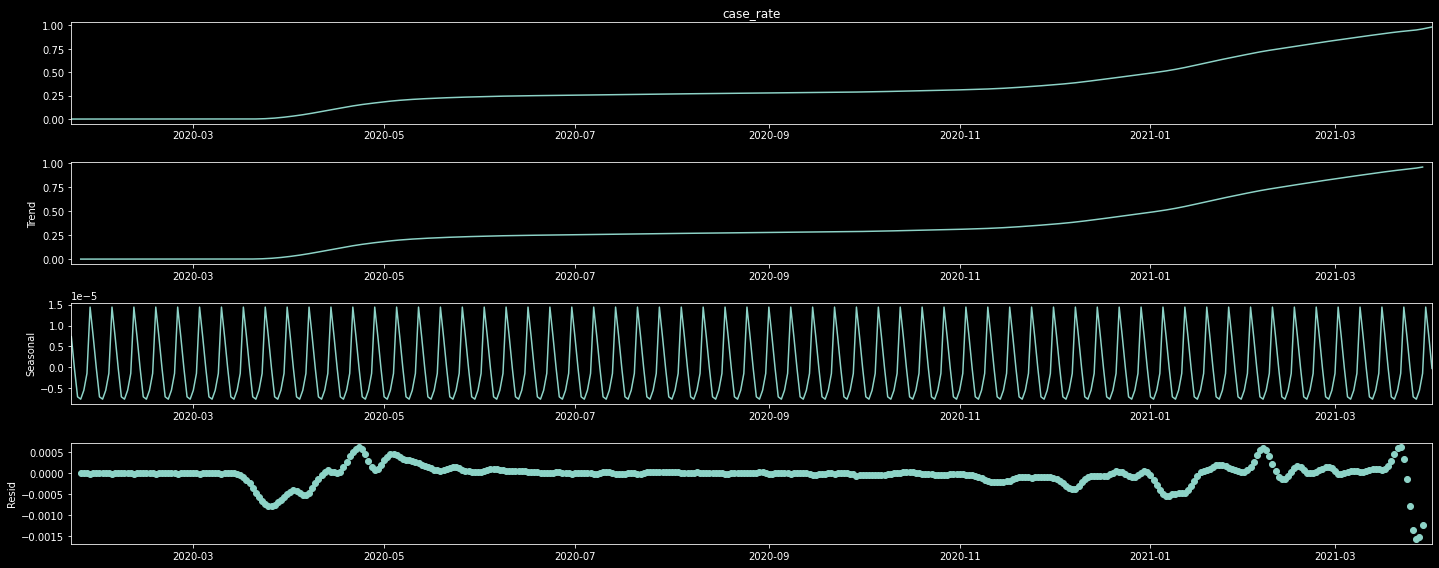

In [278]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_covid = seasonal_decompose(case_rate.drop(case_rate[case_rate.isna()].index), model='additive')
result_covid.plot()
plt.show()

<AxesSubplot:>

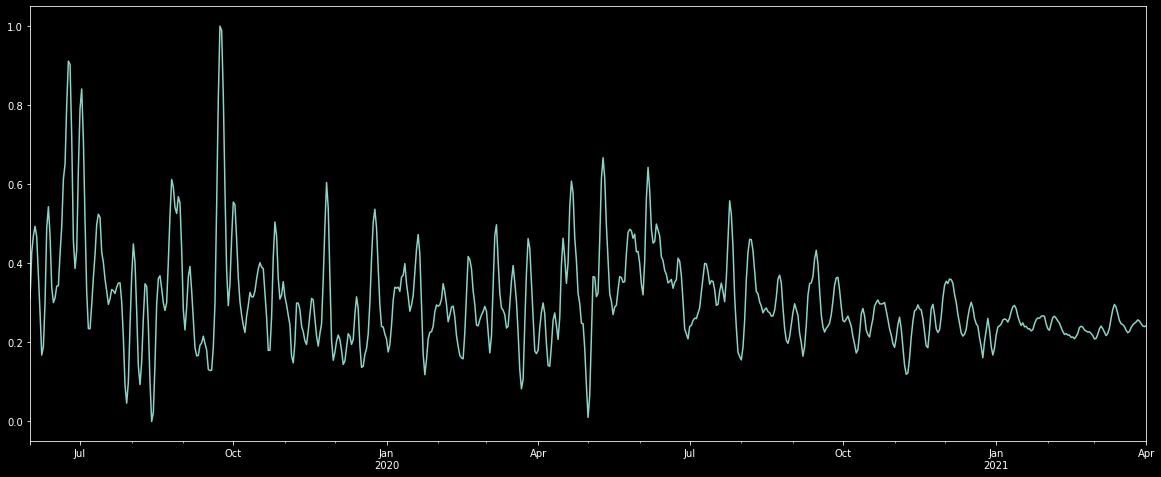

In [279]:
smoothed_df['mean'].drop(smoothed_df[smoothed_df['mean'].isna()].index).plot()

In [280]:
from statsmodels.tsa.seasonal import seasonal_decompose
result_price = seasonal_decompose(smoothed_df['mean'].drop(smoothed_df[smoothed_df['mean'].isna()].index), model='additive')

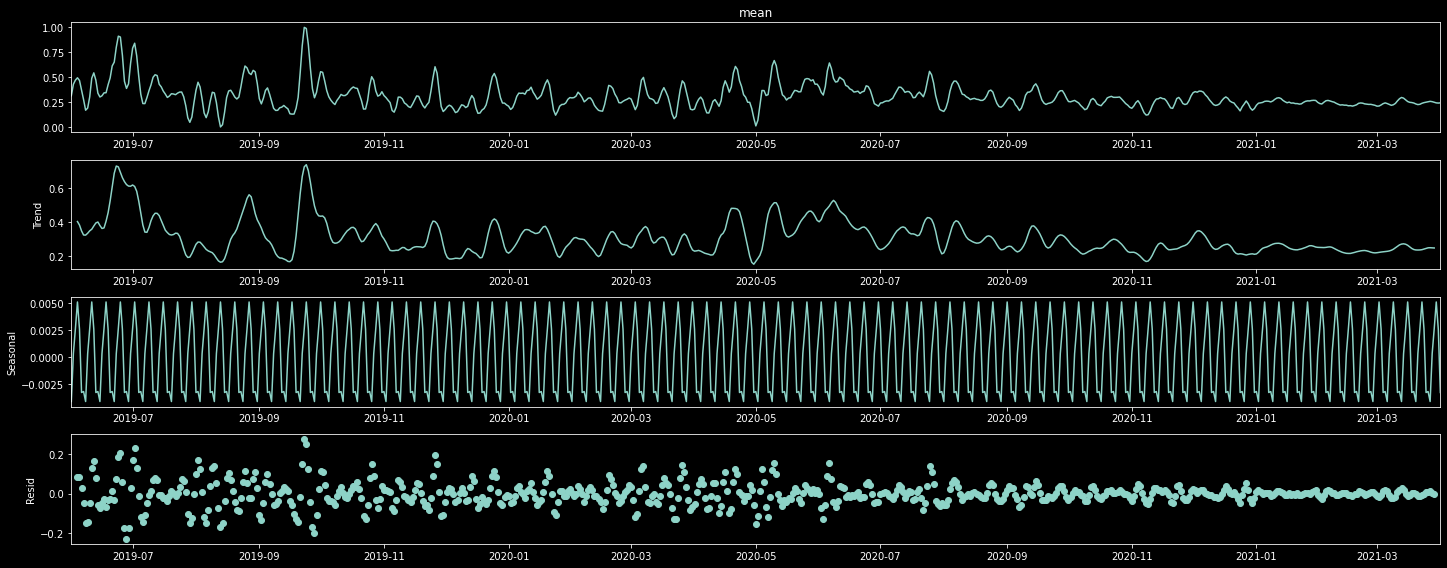

In [281]:
result_price.plot()
plt.show()

# Autocorrelation plots
Autocorrelation is used to check randomness in data. It helps to identify types of data where the period is not known.

https://stats.stackexchange.com/questions/357300/what-does-pandas-autocorrelation-graph-show]

covid case rate autocorrelation plot:

/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/misc.py:443: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

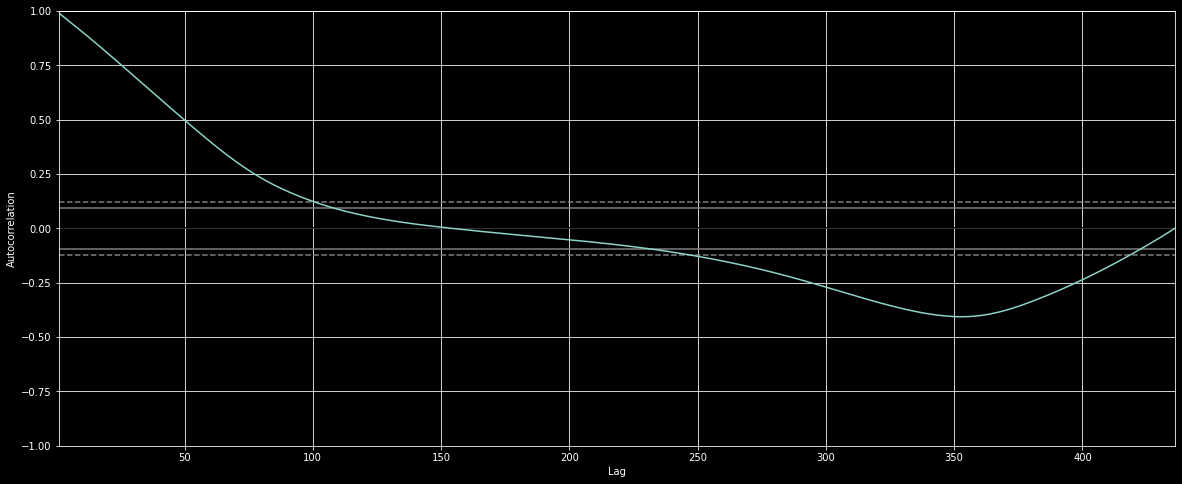

In [282]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(nyc_covid_df['case_rate'].tolist())

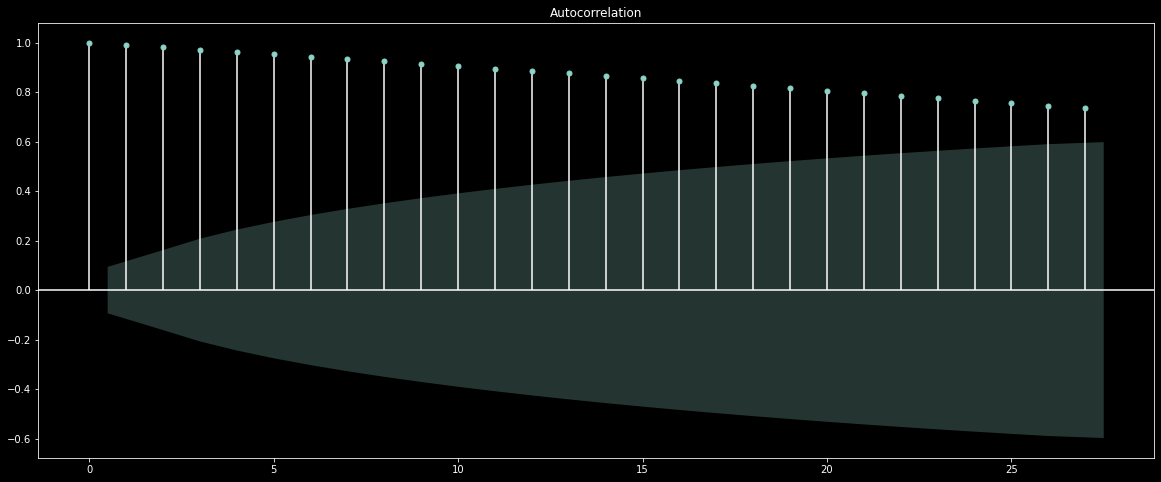

In [283]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(nyc_covid_df['case_rate'])
plt.show()

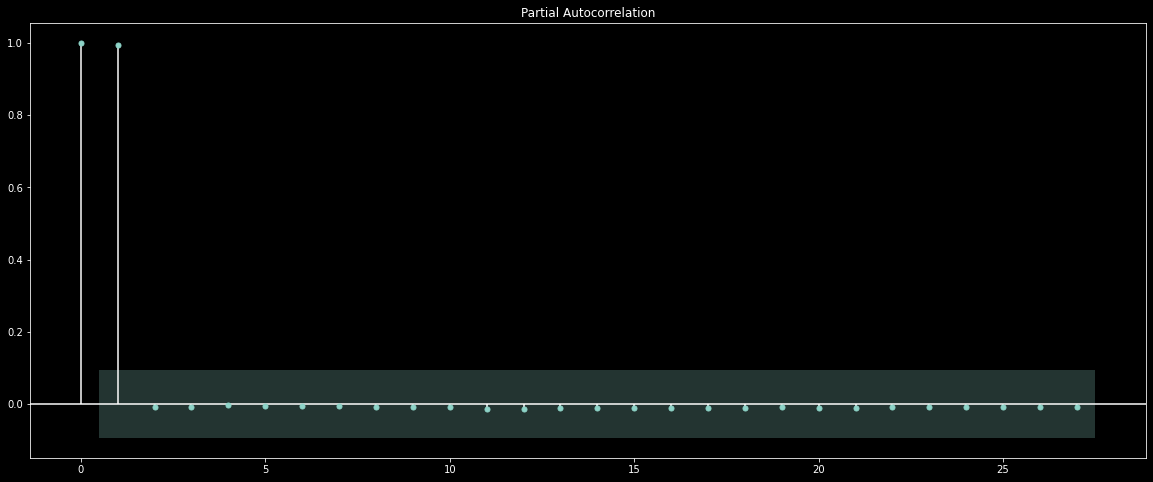

In [284]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(nyc_covid_df['case_rate'])
plt.show()

mean price and number of properties for rent autocorrelation plot:

/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/misc.py:443: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))
/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/misc.py:443: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a ne

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

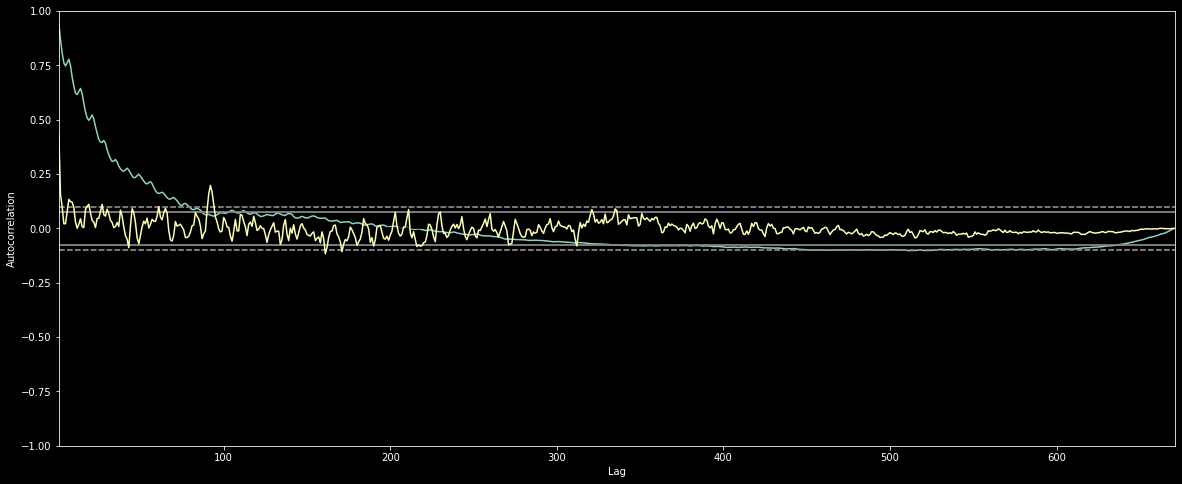

In [285]:
autocorrelation_plot(manhattan_ts['count'])
autocorrelation_plot(manhattan_ts['mean'])

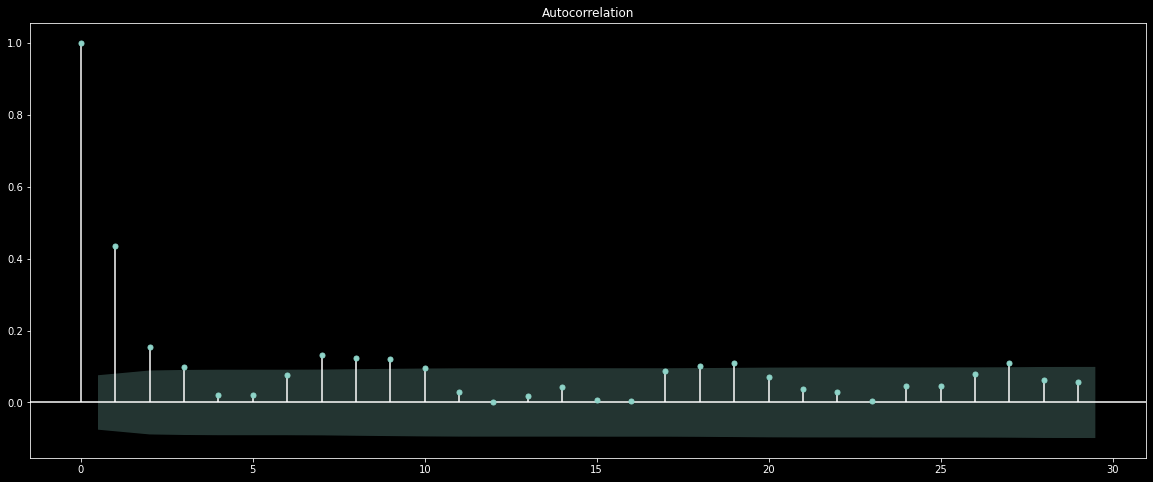

In [286]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(manhattan_ts['mean'])
plt.show()

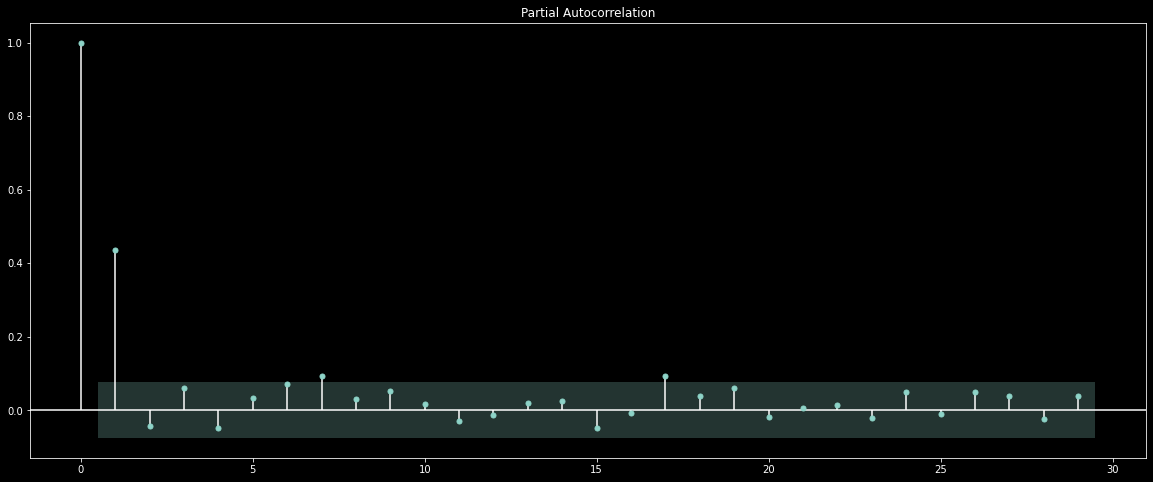

In [287]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(manhattan_ts['mean'])
plt.show()

# Cross Correlation

The first plot shows the correlation with a forward lag

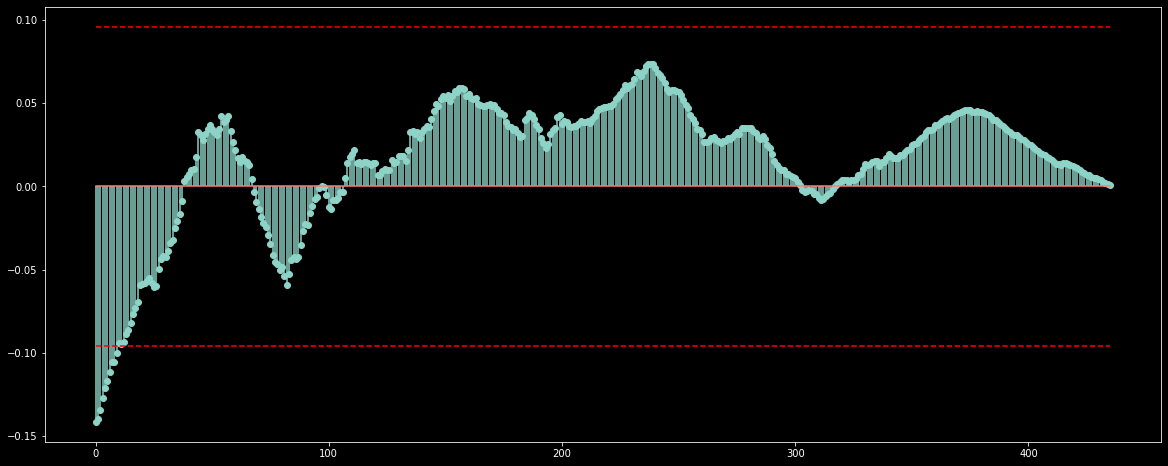

In [288]:
# correlation using just ccf and then plotting with custom function
from math import sqrt
from statsmodels.tsa.stattools import ccf

x = manhattan_ts['mean'][(manhattan_ts.index >= nyc_covid_df['new_case_rate'].index.min()) & (manhattan_ts.index <= nyc_covid_df['new_case_rate'].index.max())]
y = nyc_covid_df['new_case_rate']

cross_correlation = ccf(x, y, adjusted=False)
plt.stem(cross_correlation)
ci = 2*(1/sqrt(len(x)))
plt.plot([i for i in range(len(cross_correlation))], [ci]*len(cross_correlation), color='r', ls="--")
plt.plot([i for i in range(len(cross_correlation))], [-1*ci]*len(cross_correlation), color='r', ls="--")
plt.show()

Now we show the correlation with forward and backwards lag

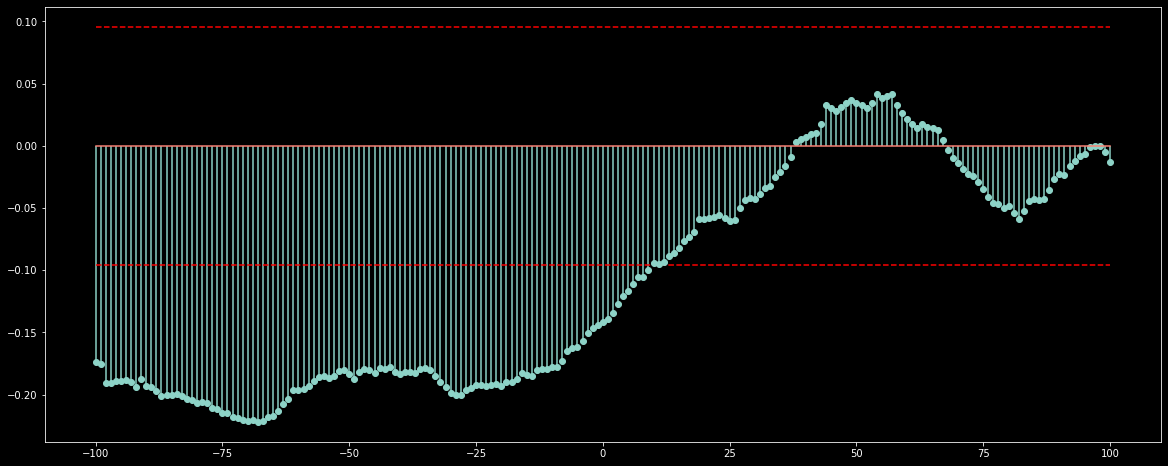

In [289]:
def ccorr_plot(x, y, values=20):
    # this function plots the cross correlation plot with positive and negative lags
    backwards = ccf(x[::-1], y[::-1], adjusted=False)[::-1][(-1*(values+1)):]
    forwards = ccf(x,y, adjusted=False)[:(values+1)]
    ccf_output = np.r_[backwards[:-1], forwards]  # we need the [:-1] because we have a duplicate for lag=0
    x_axis = list(range(-1*values, values+1))
    ci = 2*(1/sqrt(len(x)))
    plt.plot(x_axis, [ci]*len(x_axis), color='r', ls="--")
    plt.plot(x_axis, [-1*ci]*len(x_axis), color='r', ls="--")
    plt.stem(x_axis, ccf_output)
    plt.show()

ccorr_plot(x, y, 100)

# Time Series with lag

A negative value for h (lag) is a correlation between the x-variable at a time before t (the current time) and the y-variable at time t.
if h = -2 then the ccf value would give the correlation between x<sub>t-2</sub> and y<sub>t</sub>.

* if x<sub>t+h</sub> with h __negative__, is a predictor of y<sub>t</sub>, it is said that x __leads__ y.
* if x<sub>t+h</sub> with h __positive__, is a predictor of y<sub>t</sub>, it is said that x __lags__ y.

In some problems, the goal may be to identify which variable is leading and which is lagging.
In many problems we consider, though, we’ll examine the x-variable(s) to be a leading variable
of the y-variable because we will want to use values of the x-variable to predict future values of y.

I think in this case because our x is real estate and our y is covid and h is negative we can say that real estate leads covid in some weird way.
This is not what we wanted to show but it is the result we are getting.

<AxesSubplot:>

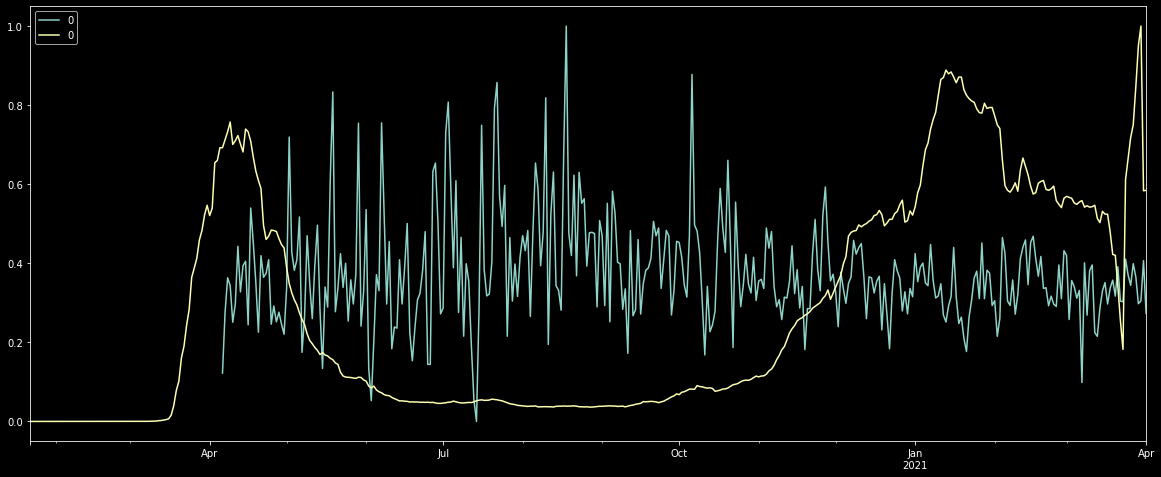

In [290]:
x = pd.DataFrame(scaler.fit_transform(np.array(x.tolist()).reshape(-1, 1)), index=x.index)
y  = pd.DataFrame(scaler.fit_transform(np.array(y.tolist()).reshape(-1, 1)), index=y.index)
df = pd.concat([x.shift(75), y], axis=1)
df.plot()

In [291]:
df.corr()

,0,0
0,1.000000,-0.247409
0,-0.247409,1.000000


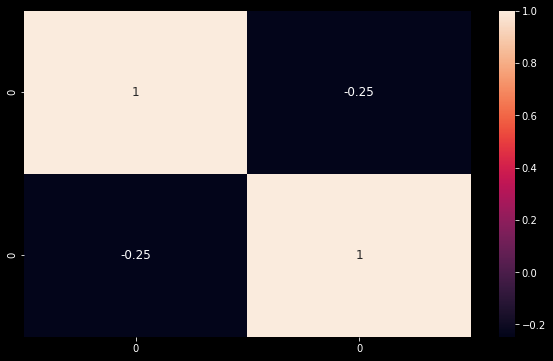

In [292]:
import seaborn as sns
corr = df.corr()
sns.heatmap(corr,xticklabels=corr.columns.values,yticklabels=corr.columns.values,annot=True,annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(10,6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [293]:
# TODO: remove seasonality and apply diff


I think there is no seasonality in the real estate data but there seems to be seasons in the case-rate of covid 
but I need to do more research on this.

# Stationary Behavior
Stationary data means that the statistical properties of the particular process (mean and variance) do not vary with time.
Most TS models work on the assumption that the TS is stationary.

To test for stationarity we can use the Dickey-Fuller test. In this test the null hypothesis is that the Time series is non-stationary.
The test results comprise of a Test Statistic and some Critical Values for difference confidence levels.
If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that
the series is stationary.

In [294]:
from statsmodels.tsa.stattools import adfuller

def dickey_fuller_test(df):
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [295]:
print("COVID Results of Dicke-Fuller Test:")
dickey_fuller_test(nyc_covid_df['case_rate'])

COVID Results of Dicke-Fuller Test:
Test Statistic                   1.475658
p-value                          0.997432
#Lags Used                      15.000000
Number of Observations Used    420.000000
Critical Value (1%)             -3.446016
Critical Value (5%)             -2.868446
Critical Value (10%)            -2.570449
dtype: float64


It seems that we can't reject the null hypothesis in the case of COVID case-rate

In [296]:
print("Rent Results of Dicke-Fuller Test:")
dickey_fuller_test(modified_manhattan_ts[~modified_manhattan_ts['mean'].isna()]['mean'])

Rent Results of Dicke-Fuller Test:
Test Statistic                  -3.361639
p-value                          0.012338
#Lags Used                      20.000000
Number of Observations Used    648.000000
Critical Value (1%)             -3.440482
Critical Value (5%)             -2.866011
Critical Value (10%)            -2.569151
dtype: float64


In the case of mean rent prices it seems that we can reject the null hypothesis and say that the time series is stationary

## Making COVID TS stationary
I think we can use the results from the decomposition that we got earlier and get the residual

In [297]:
test = result_covid.resid
test = test[~test.isna()]

Test Statistic                  -3.299000
p-value                          0.014923
#Lags Used                      18.000000
Number of Observations Used    411.000000
Critical Value (1%)             -3.446361
Critical Value (5%)             -2.868598
Critical Value (10%)            -2.570530
dtype: float64


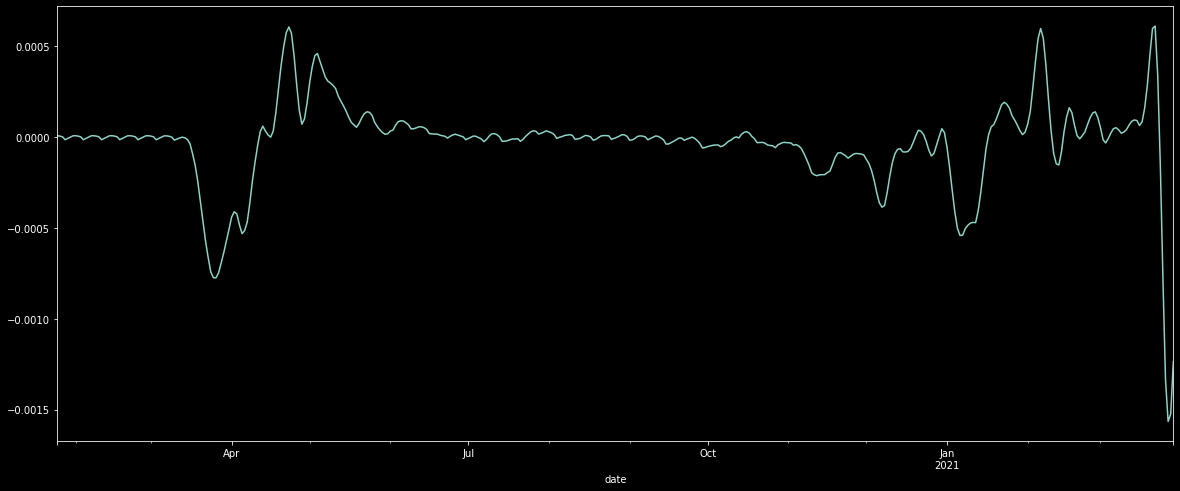

In [298]:
test.plot()
dickey_fuller_test(test)

In [299]:
x = modified_manhattan_ts['mean'][(modified_manhattan_ts.index >= test.index.min()) & (modified_manhattan_ts.index <= test.index.max())]
x

2020-01-25    0.408977
2020-01-26    0.423024
2020-01-27    0.429000
2020-01-28    0.447988
2020-01-29    0.474114
                ...   
2021-03-25    0.360470
2021-03-26    0.364745
2021-03-27    0.365485
2021-03-28    0.365144
2021-03-29    0.365779
Freq: D, Name: mean, Length: 430, dtype: float64

<AxesSubplot:>

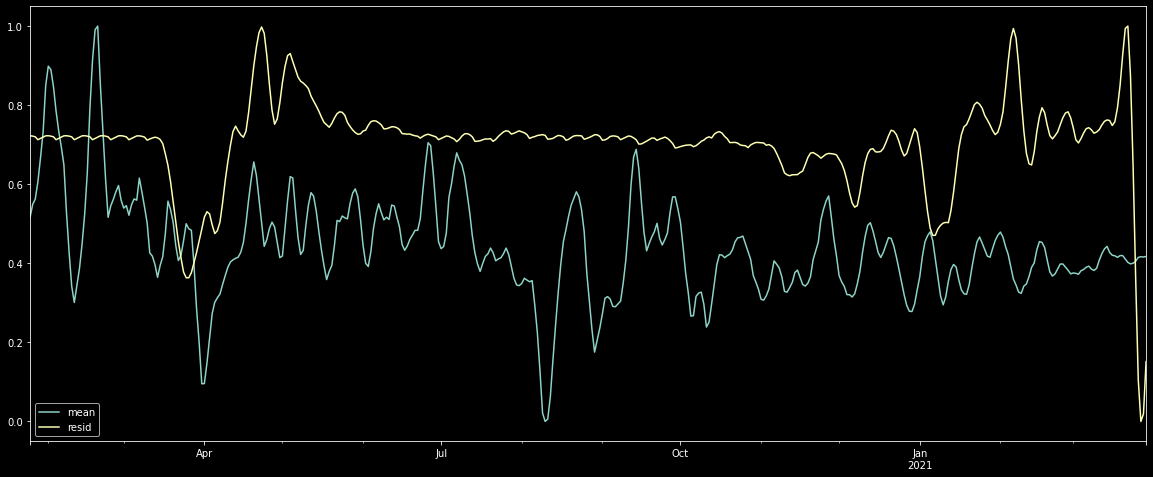

In [300]:
df = pd.concat([x, test], axis=1)
df = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)
df.plot()

In [301]:
df

,mean,resid
2020-01-25,0.516604,0.722669
2020-01-26,0.548890,0.721699
2020-01-27,0.562625,0.719848
2020-01-28,0.606265,0.712574
2020-01-29,0.666310,0.715814
...,...,...
2021-03-25,0.405121,0.362264
2021-03-26,0.414945,0.105262
2021-03-27,0.416646,0.000000
2021-03-28,0.415862,0.019070


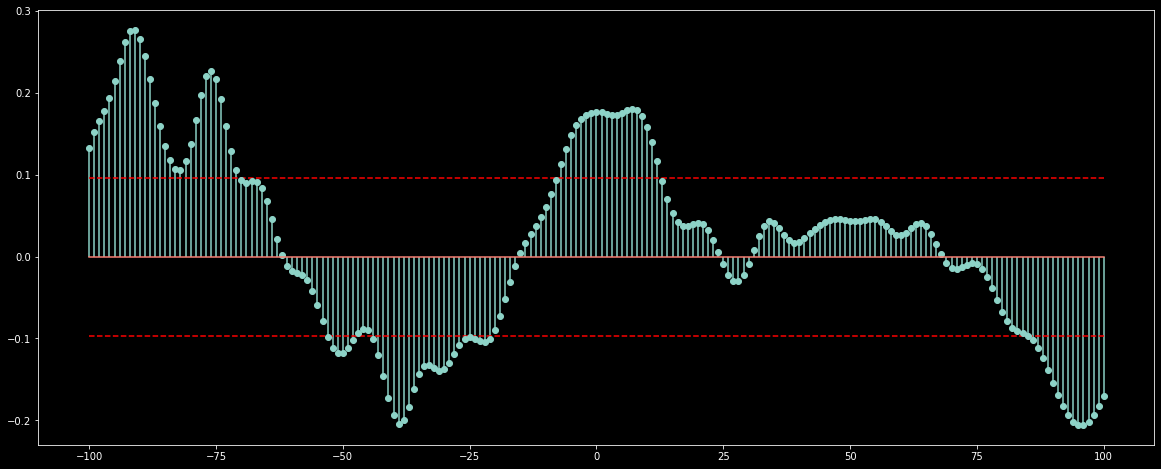

In [302]:
ccorr_plot(df['mean'], df['resid'], 100)

In [303]:
df.corr()

,mean,resid
mean,1.000000,0.177005
resid,0.177005,1.000000


Granger causality analysis rests on the assumption that if a variable X causes Y then changes in X will systematically occur 
before changes in Y. We will thus find that the lagged values of X will exhibit a statistically significant correlation with Y. 
Correlation however does not prove causation. 


# Model Evaluation


In [305]:
df

,mean,resid
2020-01-25,0.516604,0.722669
2020-01-26,0.548890,0.721699
2020-01-27,0.562625,0.719848
2020-01-28,0.606265,0.712574
2020-01-29,0.666310,0.715814
...,...,...
2021-03-25,0.405121,0.362264
2021-03-26,0.414945,0.105262
2021-03-27,0.416646,0.000000
2021-03-28,0.415862,0.019070


/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


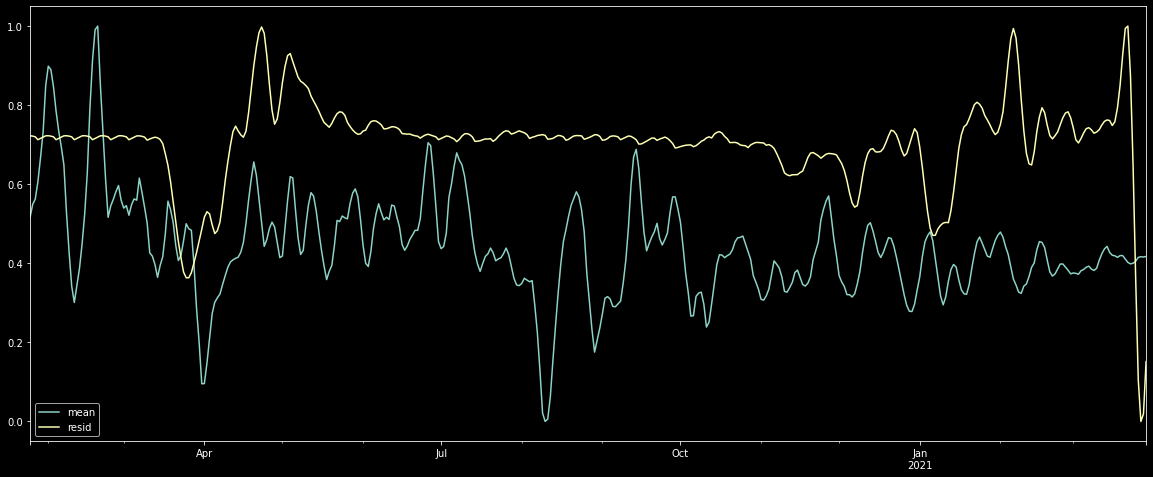

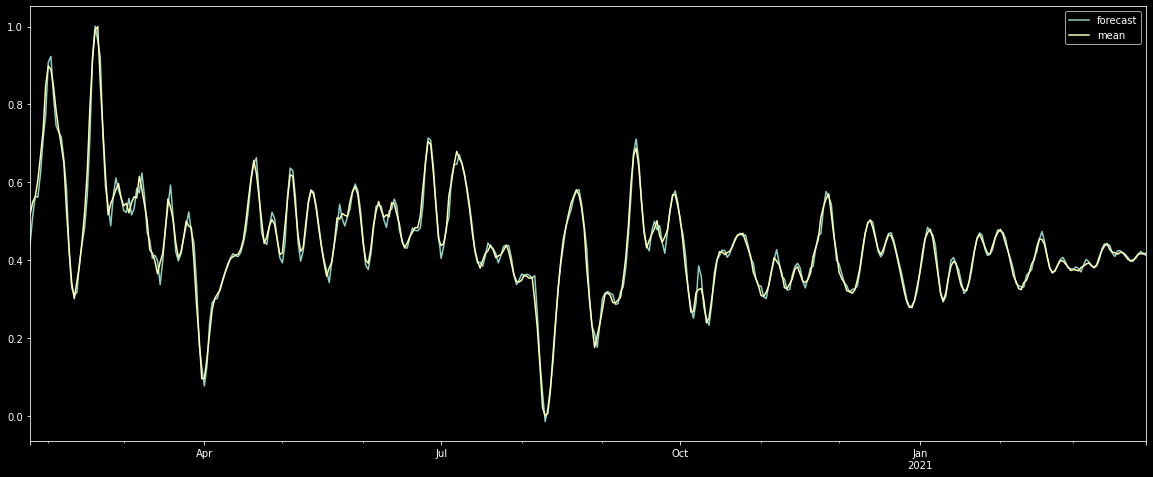

In [329]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = ARIMA(df['mean'], order=(3,0, 2))
results_AR = model.fit(disp=1)
df.plot()
# plt.plot(results_AR.predict(), color='red')
results_AR.plot_predict()
plt.show()

In [328]:
model = pm.auto_arima(df['mean'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=554.783, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-526.586, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-1522.537, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-1935.736, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-1955.937, Time=0.21 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-2036.208, Time=0.40 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-1949.966, Time=0.30 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-2166.486, Time=0.53 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-1977.781, Time=